In [350]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [351]:
df = pd.read_csv('classification-4.csv')
df = df.rename(columns={"target":"target_1"})

In [352]:
df_train,df_test = train_test_split(df, test_size=0.25,shuffle=False)

In [353]:
X_train = df_train.drop('target_1',axis=1).values
X_test = df_test.drop('target_1',axis=1).values

y_train = df_train['target_1']
y_test = df_test['target_1']



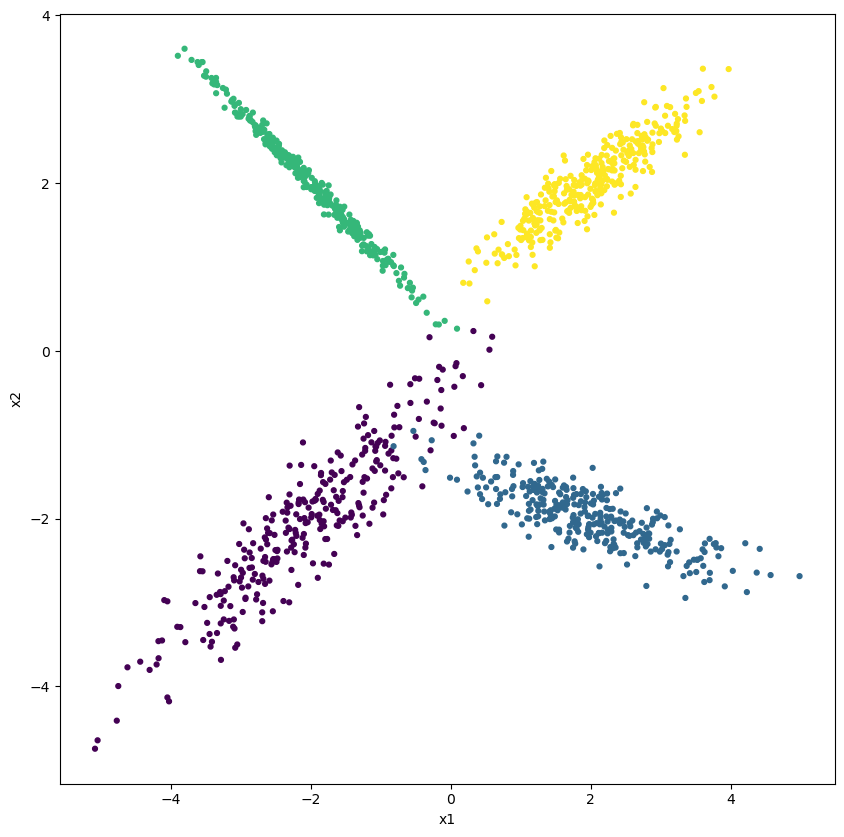

In [354]:
plt.figure(figsize=(10,10))
plt.scatter(df_test['feature_1'],df_test['feature_2'],s=12,c=df_test['target_1'],cmap="viridis")
plt.xlabel("x1")
plt.ylabel("x2")
plt.show()

In [355]:
def onehot(y):
    y = pd.DataFrame(y)
    y["target_1"] = y.iloc[:,0]
    y["target_2"] = y["target_1"]
    y["target_3"] = y["target_1"]
    y["target_4"] = y["target_1"]
    y["target_1"] = np.where(y["target_1"] == 1,1,0)
    y["target_2"] = np.where(y["target_2"] == 2,1,0)
    y["target_3"] = np.where(y["target_3"] == 3,1,0)
    y["target_4"] = np.where(y["target_4"] == 4,1,0)
    return y

y_train = onehot(y_train).values
y_test = onehot(y_test).values

In [356]:
def lrelu(x,alpha=0.01):
    return np.where(x>0,x,alpha*x)

def lrelu_d(x,alpha=0.01):
    return np.where(x>0,1,alpha)

def softmax(x):
    exp_x = np.exp(x-np.max(x,axis=1,keepdims=True))
    return exp_x / np.sum(exp_x,axis=1,keepdims=True)

In [357]:
def weight_configure(input_dim,neurons): #fully automated weight creation based on neuron and layer configuration
    w1 = np.random.randn(input_dim+1, neurons[0])
    weights = []
    for l in range(len(neurons[1:])):
        w = np.random.rand(neurons[l]+1,neurons[l+1])
        weights.append(w)
    return [w1] + weights  


In [358]:
def forward3(X,weights,activation=lrelu): #fully automated forward prop
    pre_act = []
    act = []

    X = np.concatenate([np.ones((X.shape[0], 1)), X ], axis=1)

    for weight in weights[:-1]: #every weight besides the last
        a = X @ weight #matrix multiply the previous activated function w/ bias with the weight
        pre_act.append(a) #add it to the pre_act array
        X = activation(a) #activate it
        X = np.concatenate([np.ones((X.shape[0], 1)),X], axis=1) #add bias to the activated function
        act.append(X)

    a_final = X @ weights[-1] #last weight
    pre_act.append(a_final)
    y = softmax(a_final)

    return np.array(X), pre_act, act, np.array(y)

In [ ]:
def backward2(Xc,pre_act,act,y,t,weights,activation_d=lrelu_d): #fully automated backprop
    deltas = []
    dw = []

    delta = y - t #make sure to change this if it's mathematiclly different
    deltas = [delta]
    
    for i in reversed(range(len(weights)-1)): #goes from the last weight to the 2nd one, this is backprop
        W_next = weights[i+1][:-1,:]
        delta = activation_d(pre_act[i]) * (delta @ W_next.T) 
        deltas.insert(0,delta) #put the new delta in the beginning (overwrites) so the loop uses it again

    layer_inputs = [Xc] + act[:-1]
    
    for acts,d in zip(layer_inputs,deltas):
        dw.append(acts.T @ d)
    
    return dw

In [360]:
def sgd2(weights,gradients,eta):
    new_weights = []
    for W_i, dw_i in zip(weights, gradients):
        newW = W_i - eta*dw_i
        new_weights.append(newW)
    return new_weights

In [361]:
def train_mini_batch2(X,t,eta,epochs,batch_size,neurons,activation,activation_d):
    weights = weight_configure(X.shape[1],neurons)
    N = X.shape[0]
    for epoch in range(epochs):
        indices = np.arange(N)
        np.random.shuffle(indices)
        X = X[indices]
        t = t[indices]

        for i in range(0,N,batch_size):
            X_batch = X[i:i+batch_size]
            t_batch = t[i:i+batch_size]
            Xc, pre_act, act, y = forward3(X_batch,weights,activation)
            gradients = backward2(Xc,pre_act,act,y,t_batch,weights,activation_d)
            weights = sgd2(weights,gradients,eta)
        if epoch % 100 == 0:
            _,_,_,y_full = forward3(X,weights,activation)
            eps = 1e-8
            loss = -np.mean(np.sum(t * np.log(y_full + eps), axis=1))
            print(f"Epoch {epoch}: Loss = {loss:.6f}, z3 mean = {np.mean(y_full):.4f}")
    return y_full, weights

In [362]:
eta = 0.01
epochs = 300
batch_size = 32
neurons = np.array([10,10,10,4])


train_mini_batch2(X_train,y_train,eta,epochs,batch_size,neurons,activation=lrelu,activation_d=lrelu_d)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 10 is different from 4)